# Assigment 2 Deep Learning
### by Yeramian Kevin

In [5]:
# Import for the Assigment1
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import pickle
import copy

## Question 1

In [16]:
# Global Variable
training_file = "data_batch_1"
validation_file = "data_batch_2"
test_file = "test_batch"
data_folder = "../Assignment1/cifar-10-batches-py/"
N = 10000
K = 10
d = 3072
m = 50

# - X(d,N)
# - W1(m,d)
# - b1(m,1)
# - W2(K,m)
# - b2(K,1)

In [17]:
#Q1

# Trasnform a vector of label to a vector of hot-one(dumies)
def hot_one(y):
    Y = []
    for yi in y:
        yihot = [0] * K
        yihot[yi] = 1
        Y.append(yihot)
    return np.array(Y)
    
    
#Functions that load data from file.
def load_batch(file_name):

    with open(file_name, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    y = np.hstack(dict[b'labels'])
    X = dict[b'data'].astype(float).T / 255.0
    Y = hot_one(y).T
    return X,Y,y

#Function that normalize the data( Only mean)
#Input : - X(d,N)
#Output: - X(d,N)

def normalizeData(X):
    m = np.mean(X,1)
    X = (X.T - m).T
    return X, m
#Output:
# - W1(m,d)
# - b1(m,1)
# - W2(K,m)
# - b2(K,1)
def initializeWb(K, d, m):
    mu = 0
    sigma = 0.01
    W1 =  np.random.normal(mu, sigma, (m,d))
    b1 = np.random.normal(mu, sigma, (m,1))
    W2 =  np.random.normal(mu, sigma, (K,m))
    b2 = np.random.normal(mu, sigma, (K,1))
    return W1, b1, W2, b2



In [18]:
#Load of every datasete

X_train, Y_train, y_train = load_batch(data_folder + training_file)
X_test, Y_test, y_test = load_batch(data_folder + test_file)
X_val, Y_val, y_val = load_batch(data_folder + validation_file)

W1, b1, W2, b2 = initializeWb(K,d,m)

X_train, m = normalizeData(X_train)
X_test = (X_test.T - m).T
X_val = (X_val.T - m).T

## Question 2


In [19]:
#Output : # P (KxN)
def evaluate_Classifier(X,W1,b1,W2,b2):
    s1 = np.dot(W1,X) + b1 # KxN
    h = np.maximum(s1, 0)
    s = np.dot(W2,h) + b2
    aux = np.exp(s)
    summ = np.sum(aux, axis=0) #axis=0 sum by colum so we got 1000 therm to normalize
    p = aux / summ
    return p

In [20]:
print(evaluate_Classifier(X_train[:,:1000],W1,b1,W2,b2)[:,0])

[0.09943192 0.09980968 0.09944609 0.10216151 0.10071271 0.09957528
 0.09889213 0.1018108  0.09962397 0.09853592]


In [21]:
def compute_Cost(X, Y, W1,b1,W2,b2,lamb):
    J = 0.0
    p = evaluate_Classifier(X,W1,b1,W2,b2) # K * N
    for index in range(X.shape[1]):
        J += -np.log(np.dot(p[:,index],Y[:,index]))
    J /= X.shape[1]
    J += lamb * np.sum(np.square(W1))
    J += lamb * np.sum(np.square(W2))
    return J

In [22]:
compute_Cost(X_train[:,:1000], Y_train[:,:1000], W1,b1,W2,b2,1)

17.78330608470714

In [23]:
def compute_Accuracy(X, y, W1,b1,W2,b2):
    p = evaluate_Classifier(X,W1,b1,W2,b2) # P ( K×N)
    pred = np.argmax(p,axis=0)
    acc = 0.0
    for i in range(len(pred)):
        if(pred[i] == y[i]):
            acc += 1
    return acc /len(pred)
    

In [24]:
compute_Accuracy(X_train[:,:1000], y_train[:1000], W1,b1,W2,b2)

0.122

In [25]:
#function that compute the grad
# Input: - X(d,N)
#        - Y(KxN)
#        - P(K×N)
#        - W1(m,d)
#        - b1(m,1)
#        - W2(K,m)
#        - b2(K,1)
#        - lambda
# Output:- grad_W(K×d)
#        - grad_b(K×1)
def compute_Gradients(X, Y, p, W1,b1,W2,b2, lamb):
    m = W2.shape[1]
    K = W2.shape[0]
    d = X.shape[0]
    N = X.shape[1]
    grad_W1 = np.zeros((m,d))
    grad_b1 = np.zeros((m,1))
    grad_W2 = np.zeros((K,m))
    grad_b2 = np.zeros((K,1))
    
    s1 = np.dot(W1,X) + b1 # KxN
    hh = np.maximum(s1, 0)
    
    g = - (Y.T - p.T).T #(KxN)
    grad_b2 += np.mean(g, axis=-1, keepdims=True)  
    grad_W2 += np.dot(g,hh.T)
    grad_W2 /= N
    grad_W2 += 2 * lamb * W2
    
    g = np.dot(g.T,W2)
    g1 = np.where(s1 > 0, 1, 0)
    g = np.multiply(g.T, g1)
    grad_b1 += np.mean(g, axis=-1, keepdims=True) 
    grad_W1 += np.dot(g,X.T)
    grad_W1 /= N
    grad_W1 += 2 * lamb * W1
    return grad_W1,grad_b1,grad_W2,grad_b2

def compute_Gradients_Num(X, Y, P, W1,b1,W2,b2, lamb, h):
    m = W2.shape[1]
    K = W2.shape[0]
    d = X.shape[0]
    N = X.shape[1]
    
    grad_W1 = np.zeros((m,d))
    grad_b1 = np.zeros((m,1))
    grad_W2 = np.zeros((K,m))
    grad_b2 = np.zeros((K,1))
    c =  compute_Cost(X, Y, W1,b1,W2,b2, lamb)
    
    for i in range(len(b1)):
            
        b_try = np.copy(b1)
        b_try[i] += h
       
        c2 = compute_Cost(X, Y, W1,b_try,W2,b2, lamb)
        grad_b1[i] = (c2 - c) / h
        
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W_try = np.copy(W1)
            W_try[i][j] += h
            c2 = compute_Cost(X, Y, W_try,b1,W2,b2, lamb)
            grad_W1[i][j] = (c2 - c) / h
            
    for i in range(len(b2)):
            
        b_try = np.copy(b2)
        b_try[i] += h
       
        c2 = compute_Cost(X, Y, W1,b1,W2,b_try, lamb)
        grad_b2[i] = (c2 - c) / h
        
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W_try = np.copy(W2)
            W_try[i][j] += h
            c2 = compute_Cost(X, Y, W1,b1,W_try,b2, lamb)
            grad_W2[i][j] = (c2 - c) / h
    return grad_W1,grad_b1,grad_W2,grad_b2



def compute_Gradients_Slow(X, Y, P, W1,b1,W2,b2, lamb, h):
    m = W2.shape[1]
    K = W2.shape[0]
    d = X.shape[0]
    N = X.shape[1]
    
    grad_W1 = np.zeros((m,d))
    grad_b1 = np.zeros((m,1))
    grad_W2 = np.zeros((K,m))
    grad_b2 = np.zeros((K,1))

    for i in range(len(b1)):
        
        b_try = np.copy(b1)
        b_try[i] -= h
        c1 = compute_Cost(X, Y, W1,b_try,W2,b2, lamb)
        b_try = np.copy(b1)
        b_try[i] += h
        c2 = compute_Cost(X, Y, W1,b_try,W2,b2, lamb)
        grad_b1[i] = (c2 - c1) / (h * 2)
        
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W_try = np.copy(W1)
            W_try[i][j] -= h
            c1 = compute_Cost(X, Y, W_try,b1,W2,b2, lamb)
            W_try = np.copy(W1)
            W_try[i][j] += h
            c2 = compute_Cost(X, Y, W_try,b1,W2,b2, lamb)
            grad_W1[i][j] = (c2 - c1) / (h * 2)
            
    for i in range(len(b2)):
        
        b_try = np.copy(b2)
        b_try[i] -= h
        c1 = compute_Cost(X, Y, W1,b1,W2,b_try, lamb)
        b_try = np.copy(b2)
        b_try[i] += h
        c2 = compute_Cost(X, Y, W1,b1,W2,b_try, lamb)
        grad_b2[i] = (c2 - c1) / (h * 2)
        
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W_try = np.copy(W2)
            W_try[i][j] -= h
            c1 = compute_Cost(X, Y, W1,b1,W_try,b2, lamb)
            W_try = np.copy(W2)
            W_try[i][j] += h
            c2 = compute_Cost(X, Y, W1,b1,W_try,b2, lamb)
            grad_W2[i][j] = (c2 - c1) / (h * 2)
    return grad_W1,grad_b1,grad_W2,grad_b2

In [57]:
X = X_train[:,:100]
Y = Y_train[:,:100]
p = evaluate_Classifier(X,W1,b1,W2,b2)
h = 1e-6
lamb = 1

grad_W1,grad_b1,grad_W2,grad_b2 = compute_Gradients(X, Y, p, W1,b1,W2,b2, lamb)
grad_W11,grad_b11,grad_W21,grad_b21 = compute_Gradients_Slow(X, Y, p, W1,b1,W2,b2, lamb, h)


print(np.linalg.norm(grad_b1 - grad_b11,ord=1) / max(h ,np.linalg.norm(grad_b1 ,ord=1) + np.linalg.norm(grad_b11 ,ord=1)))
print(np.linalg.norm(grad_W1 - grad_W11,ord=1) / max(h ,np.linalg.norm(grad_W1 ,ord=1) + np.linalg.norm(grad_W11 ,ord=1)))
print(np.linalg.norm(grad_b2 - grad_b21,ord=1) / max(h ,np.linalg.norm(grad_b2 ,ord=1) + np.linalg.norm(grad_b21 ,ord=1)))
print(np.linalg.norm(grad_W2 - grad_W21,ord=1) / max(h ,np.linalg.norm(grad_W2 ,ord=1) + np.linalg.norm(grad_W21 ,ord=1)))

8.304930410861635e-08
2.7643282035954512e-08
3.424281041524184e-08
2.668798337329526e-09


## Question 3

In [26]:
def fit(X, Y, y, X_val, Y_val, y_val, lamb, n_batch, rho, eta , n_epochs, K, m):
    d = X.shape[0]
    N = X.shape[1]
    
    W1, b1, W2, b2 = initializeWb(K,d,m)
    lostTrain = []
    lostVal = []
    
    W1_momentum = np.zeros((m,d))
    b1_momentum = np.zeros((m,1))
    W2_momentum = np.zeros((K,m))
    b2_momentum = np.zeros((K,1))
    
    for _ in range(n_epochs):
        for j in range(int(N / n_batch)):
            
            start = j * n_batch
            end = (j + 1) * n_batch
            X_batch = X[:,start:end]
            Y_batch = Y[:,start:end]
            p = evaluate_Classifier(X_batch,W1,b1,W2,b2)
            grad_W1,grad_b1,grad_W2,grad_b2 = compute_Gradients(X_batch, Y_batch, p, W1,b1,W2,b2, lamb)
            W1_momentum = W1_momentum * rho +  eta * grad_W1
            b1_momentum = b1_momentum * rho +  eta * grad_b1
            W2_momentum = W2_momentum * rho +  eta * grad_W2
            b2_momentum = b2_momentum * rho +  eta * grad_b2
            
            W1 -= W1_momentum
            W2 -= W2_momentum
            b1 -= b1_momentum
            b2 -= b2_momentum
        #print("Accurency on the test = "  + str(compute_Accuracy(X_val, y_val, W1, b1, W2, b2)))
        eta *= 0.95
        lostTrain.append(compute_Cost(X, Y, W1,b1,W2,b2, lamb))
        lostVal.append(compute_Cost(X_val, Y_val, W1,b1,W2,b2, lamb))
    
    return W1, b1, W2, b2, lostTrain, lostVal

In [27]:
def plot_curve(lostTrain, lostVal):
    rr = range(len(lostVal))
    plt.plot(rr, lostVal,'green')
    plt.plot(rr, lostTrain,'blue')
    plt.title("loss during the training for eta = " + str(eta) + " lambda = " + str(lamb))
    green_patch = mpatches.Patch(color='blue', label="Training loss")
    blue_patch = mpatches.Patch(color='green', label="Validation loss")
    plt.legend(handles=[green_patch, blue_patch])
    plt.savefig(str(lamb) + '_'+ str(eta) + '.png')
    plt.show()

### Question 4

In [28]:
# To test one parameter
N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 0.0001
m = 50
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]

n_batch= 100
eta= 0.02
n_epochs= 5
rho = 0.9
W1, b1, W2, b2, lostTrain, lostVal = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, K, m)
print("Accurency on the test = "  + str(compute_Accuracy(X_test, y_test, W1, b1, W2, b2)))

Accurency on the test = 0.4265


## Grid Search

In [35]:
eta_start = 0.01
eta_end = 0.1
eta_number = 20
eta_step = (eta_end - eta_start) / eta_number
grid_eta = np.arange(eta_start, eta_end, eta_step)


lamb_start = 0.00001
lamb_end = 0.0001
lamb_number = 10
lamb_step = (lamb_end - lamb_start) / lamb_number
grid_lamb = np.arange(lamb_start, lamb_end, lamb_step)


N = 10000
N_bis = 9000
K = 10
d = 3072


X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val = X_train[:,N_bis:]
Y_val = Y_train[:,N_bis:]
y_val = y_train[N_bis:]

n_batch= 100
n_epochs= 5
rho = 0.9

best_score = 0.0
best_lamb = 0
best_eta = 0
result = []
for lamb in grid_lamb:
    for eta in grid_eta:
        W1, b1, W2, b2, lostTrain, lostVal = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, K, m)
        acc = compute_Accuracy(X_val, y_val, W1, b1, W2, b2)
        result.append((acc,lamb,eta))


In [36]:

print(sorted(result)[-1])

(0.455, 2.8000000000000003e-05, 0.0685)


### Plot part

In [37]:
def plot_curve(lostTrain, lostVal):
    rr = range(len(lostVal))
    plt.plot(rr, lostVal,'green')
    plt.plot(rr, lostTrain,'blue')
    plt.title("loss during the training for eta = " + str(eta) + " lambda = " + str(lamb))
    green_patch = mpatches.Patch(color='blue', label="Training loss")
    blue_patch = mpatches.Patch(color='green', label="Validation loss")
    plt.legend(handles=[green_patch, blue_patch])
    plt.savefig(str(lamb) + '_'+ str(eta) + '.png')
    plt.show()

In [46]:
N = 10000
N_bis = 9000
K = 10
d = 3072
lamb = 2.8000000000000003e-05#7.3e-05
m = 50
X = X_train[:,:N_bis]
Y = Y_train[:,:N_bis]
y = y_train[:N_bis]

X_val, Y_val, y_val = load_batch(data_folder + validation_file)
n_batch= 100
eta=  0.0685#0.046
n_epochs= 10
rho = 0
W1, b1, W2, b2, lostTrain, lostVal = fit(X, Y, y, X_val, Y_val, y_val,  lamb, n_batch, rho, eta, n_epochs, K, m)
print("Accurency on the test = "  + str(compute_Accuracy(X_test, y_test, W1, b1, W2, b2)))



Accurency on the test = 0.2461


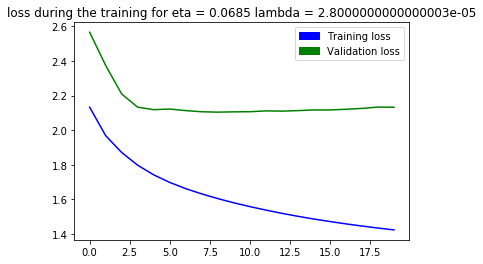

In [45]:
plot_curve(lostTrain, lostVal)